Do not select run all, otherwise presaved graphs might be deleted

In [3]:
!pip install transformers
!pip install sentence-transformers

MODEL = "microsoft/SportsBERT" model used

In [4]:
import pandas as pd
import numpy as np
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os, gc
gc.collect()
# torch.cuda.empty_cache()
# MODEL = "bert-base-uncased"
# MODEL = "distilbert-base-cased"
MODEL = "microsoft/SportsBERT"

In [5]:
# from stop_words import get_stop_words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# stop_words = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(stopwords.words('english')) #About 150 stopwords
print(nltk_words)
# stop_words.extend(nltk_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Text preprocessing functions.
Please change the file path to the destination location where the file is stored.

In [8]:
def get_result(home, away):
  if home>away:
    return(1)
  else:
    return(0)

def get_season(seas):
  s = seas.split('/')
  return(int(s[1]))

def get_clean_commentary(c):
  s= c.split('.')
  cs = ""
  for i in s[:-1]:
    cs = cs+ i
  return(cs)

def get_sentence(ht, at, sent):
        sent = sent.replace(ht,"hometeam")
        sent = sent.replace(at, "awayteam")
        # for w in nltk_words:
        #   sent = sent.replace(" "+w+" ", " ")
        return(sent)

def get_val(x):
  # print(x)
  if x=="L":
    return(-1)
  elif x=="W":
    return(1)
  elif x=="D":
    return(0)
  return(0)

def get_prev_vec(x, team):
  vec = 0
  for i in range(5):
    dec = x[team+"M"+str(i+1)]
    vec += get_val(dec)
  return(vec/5.0)





data = pd.read_csv("/content/gdrive/MyDrive/NLP_project/replaced_commentary.tsv", sep="\t")
display(data.head(5))
data["Result"] = data.apply(lambda x: get_result(x["FTHG"], x["FTAG"]), axis=1)
data["Season"] = data.apply(lambda x: get_season(x["Season"]), axis=1)
data["prev_res_h"] = data.apply(lambda x: get_prev_vec(x,"H"), axis=1)
data["prev_res_a"] = data.apply(lambda x: get_prev_vec(x,"A"), axis=1)
data["Commentary"] = data.apply(lambda x: get_clean_commentary(x["Commentary"]), axis=1)
data["Commentary"] = data.apply(lambda x: get_sentence(x["HomeTeam"],x["AwayTeam"],x["Commentary"]), axis=1)
data = data[["HomeTeam", "AwayTeam","Season","Result","prev_res_h", "prev_res_a","Commentary"]]
display(data.head(5))
print(data.iloc[1,4])

,Unnamed: 0.1,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,...,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,Commentary,Season
0,0,0,22/02/2014,Arsenal,Sunderland,4,1,H,48,25,...,5.2,10.00,1.30,5.5,10.00,1.33,4.5,11.00,gus Sunderland says the excitement at Sunderla...,13/14
1,1,1,22/02/2014,Chelsea,Everton,1,0,H,48,37,...,4.0,6.10,1.57,4.0,6.00,1.60,3.4,7.00,before a reunion with didier drogba in midweek...,13/14
2,2,2,22/02/2014,Crystal Palace,Manchester United,0,2,NH,18,41,...,3.6,1.65,6.00,4.0,1.57,6.00,3.6,1.62,this promises to be an awkward test for Manche...,13/14
3,3,3,22/02/2014,Manchester City,Stoke City,1,0,H,69,27,...,7.0,15.00,1.18,7.0,15.00,1.20,6.0,15.00,this visit of Stoke City Manchester City is th...,13/14
4,4,4,22/02/2014,West Brom,Fulham,1,1,NH,30,26,...,3.5,4.20,1.80,3.6,4.33,1.80,3.5,4.50,felix Fulham has always been known as a tough ...,13/14


,HomeTeam,AwayTeam,Season,Result,prev_res_h,prev_res_a,Commentary
0,Arsenal,Sunderland,14,1,0.4,0.4,gus awayteam says the excitement at awayteam h...
1,Chelsea,Everton,14,1,0.6,-0.4,before a reunion with didier drogba in midweek...
2,Crystal Palace,Manchester United,14,0,0.2,-0.2,this promises to be an awkward test for awayte...
3,Manchester City,Stoke City,14,1,0.4,-0.2,this visit of awayteam hometeam is the last le...
4,West Brom,Fulham,14,0,-0.4,-0.8,felix awayteam has always been known as a toug...


0.6


In [ ]:
display(data.head(5))
print(data.iloc[1,4])

,HomeTeam,AwayTeam,Season,Result,prev_res_h,prev_res_a,Commentary
0,Arsenal,Sunderland,14,1,0.4,0.4,gus awayteam says the excitement at awayteam h...
1,Chelsea,Everton,14,1,0.6,-0.4,before a reunion with didier drogba in midweek...
2,Crystal Palace,Manchester United,14,0,0.2,-0.2,this promises to be an awkward test for awayte...
3,Manchester City,Stoke City,14,1,0.4,-0.2,this visit of awayteam hometeam is the last le...
4,West Brom,Fulham,14,0,-0.4,-0.8,felix awayteam has always been known as a toug...


0.6


Dataset loader

In [9]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        super(BertDataset, self).__init__()
        self.data = data
        self.tokenizer=tokenizer
        self.max_length=max_length
        
    def __len__(self):
        return len(self.data)
      
    def get_sentence(self, ht, at, sent):
        sent = sent.replace(ht,"home team")
        sent = sent.replace(at, "away team")
        # for w in nltk_words:
        #   sent = sent.replace(w, " ")
        return(sent)

    
    def __getitem__(self, index):
        
        text1 = self.data.iloc[index,6]
        
        inputs = self.tokenizer.encode_plus(text1, padding='max_length',max_length=self.max_length, return_attention_mask=True)

        return {'token': torch.tensor(inputs["input_ids"]),
                'mask':torch.tensor(inputs["attention_mask"]),
                'target': torch.tensor(self.data.iloc[index,3], dtype=torch.long),
                'prev_h':torch.tensor([self.data.iloc[index,4]]).float(),
                'prev_a':torch.tensor([self.data.iloc[index,5]]).float()
        }

In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL,do_lower_case=True, add_special_tokens=True,)
tokenizer.add_tokens(["hometeam", "awayteam"])
tokenizer_len = len(tokenizer)

In [11]:
print(len(tokenizer))

10002


In [12]:
train_data = shuffle(data[(data["Season"]!=18)][5:])
test_data = data[(data["Season"]==18)][5:]
print(len(train_data), len(test_data))

1016 272


In [23]:
display(train_data.groupby(["Result"]).count())
display(test_data.groupby(["Result"]).count())
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_data["Result"].to_numpy()), y = train_data["Result"].to_numpy())
print(class_weights)


,HomeTeam,AwayTeam,Season,prev_res_h,prev_res_a,Commentary
Result,,,,,,
0,549,549,549,549,549,549
1,467,467,467,467,467,467


,HomeTeam,AwayTeam,Season,prev_res_h,prev_res_a,Commentary
Result,,,,,,
0,146,146,146,146,146,146
1,126,126,126,126,126,126


[0.92531876 1.08779443]


In [14]:
train_dataset = BertDataset(train_data, tokenizer, max_length=300)
train_loader=DataLoader(dataset=train_dataset,batch_size=8, shuffle=True)

test_dataset = BertDataset(test_data, tokenizer, max_length=300)
test_loader=DataLoader(dataset=test_dataset,batch_size=8, shuffle=True)

Creating model class

In [15]:
class BERT(nn.Module):
    def __init__(self, tokenizer_len):
        super(BERT, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained(MODEL)
        self.bert_model.resize_token_embeddings(tokenizer_len)
        for param in self.bert_model.parameters():
          param.requires_grad = True
        self.batch_norm = nn.BatchNorm1d(768)
        self.batch_norm1 = nn.BatchNorm1d(100)
        self.batch_norm2 = nn.BatchNorm1d(10)
        self.fc1 = nn.Linear(768,100)
        self.fc2 = nn.Linear(100,10)
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self,token, mask):
        o2= self.bert_model(token, attention_mask = mask).pooler_output
        out = self.batch_norm(o2)
        out= self.tanh(self.fc1(out)) #[:,0,:])   
        out = self.batch_norm1(out)         
        out= self.tanh(self.fc2(out))     
        out= self.sigmoid(self.fc3(out))
        
        return out
    


In [16]:
model=BERT(tokenizer_len)
weights = torch.tensor(class_weights).float()
weights = weights.to(device)
loss_fn = nn.BCELoss()

#Initialize Optimizer


Some weights of the model checkpoint at microsoft/SportsBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at microsoft/SportsBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
Y

In [17]:
# lr = 0.0001
optimizer= optim.Adam(model.parameters(),lr= 1e-7)
# model.config

In [19]:
# for param in model.bert_model.parameters():
#     param.requires_grad = False

train_accuracy = []
test_accuracy = []
train_loss = []

# metric = MulticlassF1Score(num_classes=3)
# metric = metric.to(device)

Model training function

In [20]:
def finetune(epochs,dataloader,test_loader, model,loss_fn,optimizer):
    model = model.to(device)
    
    model.train()
    for  epoch in range(epochs):
        # print(epoch)
        
        # loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
        # model.train()
        global_acc = []
        global_loss = []
        global_test = []
        
        global_f1_tr = []
        global_prec_tr = []
        global_recall_tr = []

        global_f1_te = []
        global_prec_te = []
        global_recall_te = []

        for batch, dl in enumerate(dataloader):
            # print(dl)
            token = dl["token"].to(device)
            mask = dl["mask"].to(device)
            label=dl['target'].to(device)
            # print(mask)
            if label.shape[0]!=1:
              label = label.squeeze(dim=-1).to(device)
            # print(label)
            
            optimizer.zero_grad()
            
            output=model(token, mask)
            # label = label.type_as(output)
            # print(label.shape)   
            output = output.squeeze(dim=-1) 
            # print(output.shape, label.shape)
            output = output.float()
            label = label.float()
          
            loss=loss_fn(output,label) #+(0.1/torch.sum((0.5-output)**2))

            loss.backward()
            
            optimizer.step()
            
            
            pred = torch.where(output>=0.5, 1,0)
            # print(pred.shape, label.shape)
            accuracy = torch.mean((pred==label).float())
            pred = pred.cpu()
            label=label.cpu()
            f1 = f1_score(label, pred, average='binary', zero_division=0)
            prec = precision_score(label, pred, average='binary', zero_division=0)
            recall = recall_score(label, pred, average='binary', zero_division=0)
            global_f1_tr.append(f1)
            global_prec_tr.append(prec)
            global_recall_tr.append(recall)
            print("Tr: ",pred, label)
            print("Tr: ", accuracy.item(), f1, prec, recall)
            # print("Epoc: %d , Batch: %d Acuracy: %.3f"%(epoch, batch, accuracy.item()))
            global_acc.append(accuracy.item())
            global_loss.append(loss.item())
        
        model.eval()
        
        for i, dl in enumerate(test_loader):
            with torch.no_grad():
              token = dl["token"].to(device)
              mask = dl["mask"].to(device)
              label=dl['target'].to(device)

              # if label.shape[0]!=1:
              #   label = label.squeeze().to(device)
              # else:
              # label = torch.reshape(label, (-1,1))

              # label = label.squeeze().to(device)
              
              output=model(token, mask)
              pred = torch.where(output>=0.5, 1,0)
              pred = torch.reshape(pred, (-1,))  
              
              accuracy = torch.mean((pred==label).float())
              pred = pred.cpu()
              label=label.cpu()
              f1 = f1_score(label, pred, average='binary', zero_division=0)
              prec = precision_score(label, pred, average='binary', zero_division=0)
              recall = recall_score(label, pred, average='binary', zero_division=0)
              global_f1_te.append(f1)
              global_prec_te.append(prec)
              global_recall_te.append(recall)
              print("Te: ",pred, label)
              print("Te: ", accuracy.item(), f1, prec, recall)
              global_test.append(accuracy.item())

        mean_loss = sum(global_loss)/len(global_loss)
        mean_train_acc = sum(global_acc)/len(global_acc)
        mean_test_acc = sum(global_test)/len(global_test)
        m_tr_f1 = sum(global_f1_tr)/len(global_f1_tr)
        m_tr_prec = sum(global_prec_tr)/len(global_prec_tr)
        m_tr_recall = sum(global_recall_tr)/len(global_recall_tr)

        m_te_f1 = sum(global_f1_te)/len(global_f1_te)
        m_te_prec = sum(global_prec_te)/len(global_prec_te)
        m_te_recall = sum(global_recall_te)/len(global_recall_te)

        train_accuracy.append(mean_train_acc)
        test_accuracy.append(mean_test_acc)
        train_loss.append(mean_loss)

        print("Epoc: %d \tLoss: %.3f \tTrain Acuracy: %.3f \tTest Accuracy: %.3f"%(epoch, mean_loss, mean_train_acc, mean_test_acc))
        print("Train: Epoc: %d \tF1: %.3f \tprec: %.3f \trecall: %.3f"%(epoch, m_tr_f1, m_tr_prec, m_tr_recall))
        print("Test: Epoc: %d \tF1: %.3f \tprec: %.3f \trecall: %.3f"%(epoch, m_te_f1, m_te_prec, m_te_recall))
          

            # num_correct = sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            # num_samples = pred.shape[0]
            # accuracy = num_correct/num_samples
            
            # print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
            
            # Show progress while training
            # loop.set_description(f'Epoch={epoch}/{epochs}')
            # loop.set_postfix(loss=loss.item(),acc=accuracy.item())

    return model

Uncomment the below statement if want to see the training

In [ ]:
# model = finetune(15, train_loader, test_loader, model, loss_fn, optimizer)

Tr:  tensor([1, 1, 1, 0, 0, 1, 0, 0]) tensor([1., 1., 1., 0., 0., 0., 1., 1.])
Tr:  0.625 0.6666666666666665 0.75 0.6
Tr:  tensor([0, 0, 1, 0, 0, 0, 0, 1]) tensor([0., 0., 1., 1., 1., 0., 0., 1.])
Tr:  0.75 0.6666666666666666 1.0 0.5
Tr:  tensor([0, 0, 0, 1, 0, 0, 1, 0]) tensor([0., 1., 0., 1., 0., 0., 1., 0.])
Tr:  0.875 0.8 1.0 0.6666666666666666
Tr:  tensor([0, 1, 0, 0, 1, 0, 1, 0]) tensor([0., 1., 1., 1., 1., 0., 1., 0.])
Tr:  0.75 0.7499999999999999 1.0 0.6
Tr:  tensor([0, 0, 0, 1, 0, 1, 0, 1]) tensor([1., 0., 0., 0., 0., 0., 0., 0.])
Tr:  0.5 0.0 0.0 0.0
Tr:  tensor([0, 1, 1, 0, 0, 1, 0, 0]) tensor([0., 1., 1., 1., 0., 0., 0., 1.])
Tr:  0.625 0.5714285714285715 0.6666666666666666 0.5
Tr:  tensor([0, 1, 0, 1, 0, 0, 1, 0]) tensor([1., 0., 1., 1., 0., 0., 0., 1.])
Tr:  0.375 0.28571428571428575 0.3333333333333333 0.25
Tr:  tensor([1, 0, 1, 0, 0, 0, 1, 0]) tensor([1., 1., 1., 0., 1., 1., 1., 0.])
Tr:  0.625 0.6666666666666666 1.0 0.5
Tr:  tensor([1, 0, 0, 0, 0, 1, 0, 0]) tensor([0., 

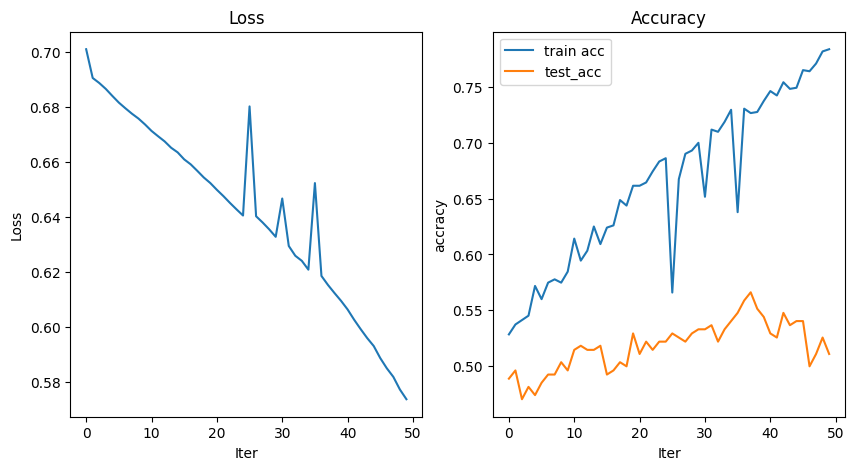

In [ ]:
import matplotlib.pyplot as plt
# train_accuracy = []
# test_accuracy = []
# train_loss = []

x = np.arange(len(train_loss))
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10, 5))
cp1 = ax1.plot(x, train_loss)
ax1.set_title('Loss')
ax1.set_xlabel('Iter')
ax1.set_ylabel('Loss')

ax2.plot(x, train_accuracy)
ax2.plot(x, test_accuracy)
ax2.set_title('Accuracy')
ax2.set_xlabel('Iter')
ax2.set_ylabel('accracy')
ax2.legend(("train acc", "test_acc"))
plt.show()


In [ ]:
# torch.save(model.state_dict(), "/content/gdrive/MyDrive/NLP_project/bert_model_2classoutput")

Test function

In [22]:
text = "Manchester United's odd league campaign will have them end in second place whatever the result versus Watford despite jose Manchester United ' s side rarely exciting or convincing . the visitors arrive safe in 13th and could end as high as 10th should they beat Manchester United and , given Watford's victory at old Manchester United in april , they may fancy their chances ."
text = text.replace("Manchester United", "hometeam")
text = text.replace("Watford", "awayteam")
# text = text.replace("'","")

model.load_state_dict(torch.load("/content/gdrive/MyDrive/NLP_project/bert_model_2classoutput", map_location=device))
inputs = tokenizer.encode_plus(text ,padding='max_length',max_length=300,return_attention_mask=True )
tokens = torch.tensor(inputs["input_ids"])
mask = torch.tensor(inputs["attention_mask"])
tokens = torch.tensor(tokens).unsqueeze(0)
mask = torch.tensor(mask).unsqueeze(0)
tokens = tokens.to(device)
mask = mask.to(device)
model.eval()
output=model(tokens, mask)
print(output)

<ipython-input-22-a547a238ca30>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens).unsqueeze(0)
<ipython-input-22-a547a238ca30>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask).unsqueeze(0)


tensor([[0.3569]], grad_fn=<SigmoidBackward0>)
